<a href="https://colab.research.google.com/github/Singhul/Projects/blob/main/GTSRB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing essential libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import math
import cv2
import os
import shutil
from google.colab import files
import pathlib

#Tensorflow stable version
%tensorflow_version 2.1.0
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.initializers import he_normal, zeros, glorot_normal, RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2, l1_l2

#Fixing python random seed
random.seed(42)
#fixing numpy random seed
np.random.seed(21)
#fixing tensorflow random seed
tf.random.set_seed(42)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
def download_dataset_from_kaggle() :
  print('Please upload the kaggle api token :')
  files.upload()
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json  # set permission

 
  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip -q /content/gtsrb-german-traffic-sign.zip -d Data
  

#Calling the function
download_dataset_from_kaggle()

Please upload the kaggle api token :


Saving kaggle.json to kaggle.json
kaggle.json
 95% 583M/612M [00:03<00:00, 191MB/s]
100% 612M/612M [00:03<00:00, 161MB/s]


In [3]:
#Run this only once
#Creating validation directory
val_dir = "/content/Data/Validation"
os.mkdir(val_dir)

n_classes = 43
train_dir = "/content/Data/Train{0}"

#Moving files from train to validation directory
for n in tqdm(range(n_classes)) :
  path = os.path.join(val_dir, str(n))
  os.mkdir(path)
  src_path = train_dir.format('/' + str(n))
  files = os.listdir(src_path)
  rand_idx = random.sample(range(len(files)), math.ceil(len(files)/4))
  for idx in rand_idx :
    src = src_path + "/" + files[idx]
    shutil.move(src, path)

100%|██████████| 43/43 [00:00<00:00, 59.13it/s]


In [4]:
#Setting up variables
IMG_WIDTH = 30
IMG_HEIGHT = 30
N_CHANNELS = 3
BATCH_SIZE = 32
N_EPOCHS = 200
VAL_BATCH_SIZE = 32
CLASS_NAMES = list(range(43))
N_CLASSES = 43
train_path = "/content/Data/Train"         #Train dataset path
val_path = "/content/Data/Validation"      #Validation dataset path


#Path to train and validation datasets
data_root_train = pathlib.Path(train_path)
data_root_val = pathlib.Path(val_path)

#Getting paths to all the images in train and validation sets
all_image_paths_train = list(data_root_train.glob('*/*'))
all_image_paths_train = [str(path) for path in all_image_paths_train]

all_image_paths_val = list(data_root_val.glob('*/*'))
all_image_paths_val = [str(path) for path in all_image_paths_val]

#Counting number of images in each sets
image_count_train = len(all_image_paths_train)
image_count_val = len(all_image_paths_val)

In [5]:
#Extracting labels for each image
label_names_train = sorted(int(item.name) for item in data_root_train.glob('*/') if item.is_dir())
label_names_val = sorted(int(item.name) for item in data_root_val.glob('*/') if item.is_dir())
label_to_index_train = dict((name, index) for index,name in enumerate(label_names_train))
label_to_index_val = dict((name, index) for index,name in enumerate(label_names_val))
all_image_labels_train = [label_to_index_train[int(pathlib.Path(path).parent.name)] for path in all_image_paths_train]
all_image_labels_val = [label_to_index_val[int(pathlib.Path(path).parent.name)] for path in all_image_paths_val]

In [6]:
#Loading dataframe
df_train = pd.read_csv("/content/Data/Train.csv")

#Updating coordinates
for idx, row in df_train.iterrows() :
  w = row['Width']
  h = row['Height']
  if w > IMG_WIDTH :
    diff = w-IMG_WIDTH
    df_train.iloc[idx, 4] = df_train.iloc[idx]['Roi.X2'] - diff
  else :
    diff = IMG_WIDTH-w
    df_train.iloc[idx, 4] = df_train.iloc[idx]['Roi.X2'] + diff
  if h > IMG_HEIGHT :
    diff = h - IMG_HEIGHT
    df_train.iloc[idx, 5] = df_train.iloc[idx]['Roi.Y2'] - diff
  else :
    diff = IMG_HEIGHT - h
    df_train.iloc[idx, 5] = df_train.iloc[idx]['Roi.Y2'] + diff

In [7]:
train_idx_list = []
val_idx_list = []

for path_tr in tqdm(all_image_paths_train) :
  train_idx_list.append(df_train[df_train['Path'] == path_tr[14 : ]].index[0])
for path_val in tqdm(all_image_paths_val) :
  path_val = "Train/" + path_val[25:]
  val_idx_list.append(df_train[df_train['Path'] == path_val].index[0])

new_df_train = pd.DataFrame()
new_df_val = pd.DataFrame()

new_df_train = new_df_train.append(df_train.iloc[train_idx_list], ignore_index = True)
new_df_val = new_df_val.append(df_train.iloc[val_idx_list], ignore_index = True)

new_df_train = new_df_train.drop(['Height', 'Width', 'ClassId', 'Path'], axis = 1)
new_df_val = new_df_val.drop(['Height', 'Width', 'ClassId', 'Path'], axis = 1)

100%|██████████| 9812/9812 [00:24<00:00, 398.14it/s]


In [8]:
def tfdata_generator(images, labels, df, is_training, batch_size=32):
  '''Construct a data generator using tf.Dataset'''
  def parse_function(filename, labels, df):
    '''Function to preprocess the images'''
    #reading path 
    image_string = tf.io.read_file(filename)
    #decoding image
    image = tf.image.decode_png(image_string, channels=N_CHANNELS)
    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    #Adjusting contrast and brightness of the image
    if tf.math.reduce_mean(image) < 0.3 :
      image = tf.image.adjust_contrast(image, 5)
      image = tf.image.adjust_brightness(image, 0.2)
    #resize the image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method="nearest", preserve_aspect_ratio=False)
    image = image/255.0
    #one hot coding for label
    #y = tf.one_hot(tf.cast(label, tf.uint8), N_CLASSES)
    return image, {"classification" : labels, "regression" : df}
  ##creating a dataset from tensorslices
  dataset = tf.data.Dataset.from_tensor_slices((images, labels, df))
  if is_training:
    dataset = dataset.shuffle(30000)  # depends on sample size
  # Transform and batch data at the same time
  dataset = dataset.map(parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  #prefetch the data into CPU/GPU
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

#Train and Validation data generators :
tf_image_generator_train = tfdata_generator(all_image_paths_train, all_image_labels_train, new_df_train, is_training=True, batch_size=32)
tf_image_generator_val = tfdata_generator(all_image_paths_val, all_image_labels_val, new_df_val, is_training=False, batch_size=32)

In [9]:
class Sharpen(tf.keras.layers.Layer):
    def __init__(self, num_outputs) :
        super(Sharpen, self).__init__()
        self.num_outputs = num_outputs

    def build(self, input_shape) :
        self.kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        self.kernel = tf.expand_dims(self.kernel, 0)
        self.kernel = tf.expand_dims(self.kernel, 0)
        self.kernel = tf.cast(self.kernel, tf.float32)

    def call(self, input_) :
        return tf.nn.conv2d(input_, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
      
def get_model() :
  #Input layer
  input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, ), name="input_layer", dtype='float32')
  #Sharpen Layer to sharpen the edges of the image.
  sharp = Sharpen(num_outputs=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, ))(input_layer)
  #Convolution, maxpool and dropout layers
  conv_1 = Conv2D(filters=32, kernel_size=(5,5), activation=relu,
                  kernel_initializer=he_normal(seed=54), bias_initializer=zeros(),
                  name="first_convolutional_layer") (sharp)
  conv_2 = Conv2D(filters=64, kernel_size=(3,3), activation=relu,
                  kernel_initializer=he_normal(seed=55), bias_initializer=zeros(),
                  name="second_convolutional_layer") (conv_1)                  
  maxpool_1 = MaxPool2D(pool_size=(2,2), name = "first_maxpool_layer")(conv_2)
  dr1 = Dropout(0.25)(maxpool_1)
  conv_3 = Conv2D(filters=64, kernel_size=(3,3), activation=relu,
                  kernel_initializer=he_normal(seed=56), bias_initializer=zeros(),
                  name="third_convolutional_layer") (dr1)
  maxpool_2 = MaxPool2D(pool_size=(2,2), name = "second_maxpool_layer")(conv_3)
  dr2 = Dropout(0.25)(maxpool_2) 
  flat = Flatten(name="flatten_layer")(dr2)

  #Fully connected layers
  d1 = Dense(units=256, activation=relu, kernel_initializer=he_normal(seed=45),
             bias_initializer=zeros(), name="first_dense_layer_classification", kernel_regularizer = l2(0.001))(flat)
  dr3 = Dropout(0.5)(d1)
  
  classification = Dense(units = 43, activation=None, name="classification",  kernel_regularizer = l2(0.0001))(dr3)
  
  regression = Dense(units = 4, activation = 'linear', name = "regression", 
                     kernel_initializer=RandomNormal(seed=43), kernel_regularizer = l2(0.1))(dr3)
  #Model
  model = Model(inputs = input_layer, outputs = [classification, regression])
  model.summary()
  return model

In [10]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, auc
import datetime
import time

#Defining cusotm callback for F1-Score
class Metrics(Callback) :
  """
  Custom callback to print the weighted F1-Score
  at the end of each training epoch.
  """
  def __init__(self, validation_data_generator) :
    self.validation_data_generator = validation_data_generator

  def on_train_begin(self, logs={}) :
    '''
    This function initializes lists to store AUC and Micro F1 scores
    '''
    self.val_f1s = []
    self.val_precisions = []
    self.val_recalls = []
    self.batches = self.validation_data_generator.as_numpy_iterator()

  def on_epoch_end(self, epoch, logs = {}) :
    '''
    This function calculates the micro f1 and auc scores
    at the end of each epochs
    '''
    current_batch = self.batches.next()
    images = current_batch[0]
    labels = current_batch[1]
    labels = labels["classification"]
    labels = np.array(labels)
    pred = self.model.predict(images)
    pred = pred[0]
    val_predict = (np.asarray(pred)).round()
    idx = np.argmax(val_predict, axis=-1)
    a = np.zeros( val_predict.shape )
    a[ np.arange(a.shape[0]), idx] = 1
    val_predict = [np.where(r==1)[0][0] for r in a]
    val_predict = np.array(val_predict)
    val_targ = labels
    _val_f1 = f1_score(val_targ, val_predict, average = 'weighted')
    _val_precision = precision_score(val_targ, val_predict, average='weighted')
    _val_recall = recall_score(val_targ, val_predict, average='weighted')
    print("\nEpoch : {0} -  Precision_Score : {1:.2f} - Recall_Score : {2:.2f} - F1_Score : {3:.2f}\n".format(epoch, _val_precision, _val_recall, _val_f1))
    self.val_f1s.append(_val_f1)
    self.val_precisions.append(_val_precision)
    self.val_recalls.append(_val_recall)
    return

#Defining loss functions for classification and regression
#Loss function for bounding box regression
def r2_keras(y_true, y_pred):
  SS_res =  K.sum(K.square(y_true - y_pred)) 
  SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#loss function for classification
loss = SparseCategoricalCrossentropy(from_logits=True)

#Compiling the model
model = get_model()
model.compile(optimizer="adam", loss = {"classification" : loss, "regression" : "mse"}, 
              metrics={"classification" : "acc", "regression" : r2_keras}, loss_weights = {"classification" : 5, "regression" : 1})

#Callbacks
#Tensorboard callback
%load_ext tensorboard
log_dir="/content/drive/My Drive/CaseStudy2/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,
                                   write_images = True)
#ModelCheckpoint
NAME = "TrafficSignRecog-first-cut-{0}".format(int(time.time()))
save_best_model = ModelCheckpoint(filepath='/content/drive/My Drive/CaseStudy2/best_models/{0}'.format(NAME), monitor='val_loss',
                                  save_best_only = True, mode = 'min', save_freq = 'epoch')

#Early stopping to avoide model overfitting
early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
metrics = Metrics(tf_image_generator_val)

#Training
history = model.fit_generator(
    generator = tf_image_generator_train, steps_per_epoch = 20, #train batch size
    epochs = 3,
    validation_data = tf_image_generator_val, validation_steps = 20, #val batch size
    callbacks = [save_best_model, tensorboard_callback, metrics, early_stop]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 30, 30, 3)]  0           []                               
                                                                                                  
 sharpen (Sharpen)              (None, 30, 30, 3)    0           ['input_layer[0][0]']            
                                                                                                  
 first_convolutional_layer (Con  (None, 26, 26, 32)  2432        ['sharpen[0][0]']                
 v2D)                                                                                             
                                                                                                  
 second_convolutional_layer (Co  (None, 24, 24, 64)  18496       ['first_convolutional_layer[0

In [27]:
def evaluate_test_images(path, model) :
  """
  Function to make predictions for the test set images
  """
  labels = []
  bbox = []
  all_imgs = path
 
 
  image_string = tf.io.read_file('/content/Data' + '/' + path)
  #Loading and decoding image
  image = tf.image.decode_png(image_string, channels=N_CHANNELS)
  #Converting image data type to float
  image = tf.image.convert_image_dtype(image, tf.float32)
  #Adjusting image brightness and contrast
  if tf.math.reduce_mean(image) < 0.3 :
    image = tf.image.adjust_contrast(image, 5)
    image = tf.image.adjust_brightness(image, 0.2)
  #Resizing image
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method="nearest", preserve_aspect_ratio=False)
  image = image/255.0
  image = np.expand_dims(image, axis=0)
  #Predicting output
  pred = model.predict(image)
  labels.append(np.argmax(pred[0][0]))
  bbox.append(pred[1][0])
  return labels, bbox

In [54]:
import cv2
from sklearn.metrics import f1_score, mean_squared_error
def final_fun_1(image_path) :
    actual_label = image_path[6]
    image_path = image_path[7]
    label = evaluate_test_images(image_path, model)
    #image = Image.open(image_path)
    coutor = np.array(label[1])
    image = cv2.imread('/content/Data' + '/' + image_path)
    x1 = coutor[0][0]
    y1 = coutor[0][1]
    x2 = coutor[0][2]
    y2 = coutor[0][3]
    start = (x1,y1)
    end = (x2,y2)
    # Blue color in BGR
    color = (255, 0, 0)
  
    # Line thickness of 2 px
    thickness = 1
    image = cv2.rectangle(image, start, end, color, thickness)
    plt.imshow(image)
    plt.show()
    print("Predicted Label : {0}".format(label[0]))
    print("Actual Label : {0}".format(actual_label-1))
    print("\n")

In [16]:

test_df = pd.read_csv('/content/Data/Test.csv')
test_df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


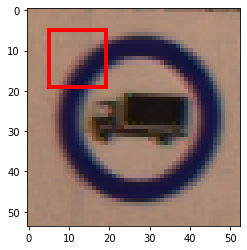

Predicted Label : [13]
Actual Label : 15




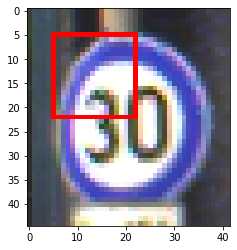

Predicted Label : [13]
Actual Label : 0




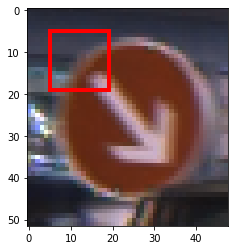

Predicted Label : [13]
Actual Label : 37




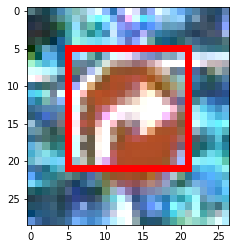

Predicted Label : [13]
Actual Label : 32




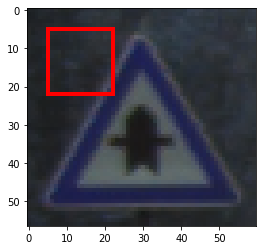

Predicted Label : [13]
Actual Label : 10




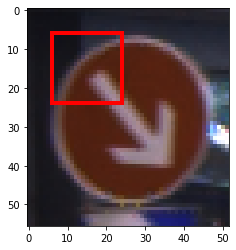

Predicted Label : [13]
Actual Label : 37




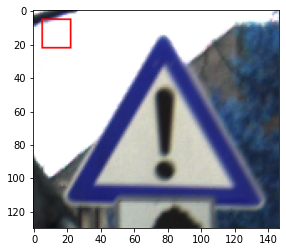

Predicted Label : [13]
Actual Label : 17




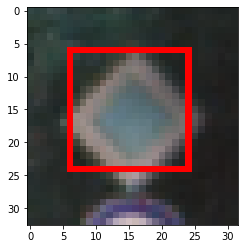

Predicted Label : [13]
Actual Label : 11




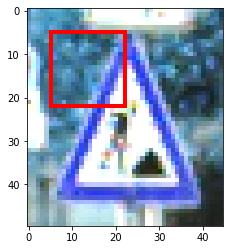

Predicted Label : [13]
Actual Label : 24




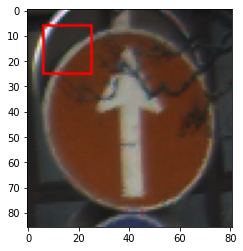

Predicted Label : [13]
Actual Label : 34




In [55]:
for itr in range(0, 10) :
  final_fun_1(test_df.iloc[itr])